In [ ]:
%matplotlib inline
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive



Finetuning Torchvision Models
=============================

**Author:** `Nathan Inkawhich <https://github.com/inkawhich>`__




In this tutorial we will take a deeper look at how to finetune and
feature extract the `torchvision
models <https://pytorch.org/docs/stable/torchvision/models.html>`__, all
of which have been pretrained on the 1000-class Imagenet dataset. This
tutorial will give an indepth look at how to work with several modern
CNN architectures, and will build an intuition for finetuning any
PyTorch model. Since each model architecture is different, there is no
boilerplate finetuning code that will work in all scenarios. Rather, the
researcher must look at the existing architecture and make custom
adjustments for each model.

In this document we will perform two types of transfer learning:
finetuning and feature extraction. In **finetuning**, we start with a
pretrained model and update *all* of the model’s parameters for our new
task, in essence retraining the whole model. In **feature extraction**,
we start with a pretrained model and only update the final layer weights
from which we derive predictions. It is called feature extraction
because we use the pretrained CNN as a fixed feature-extractor, and only
change the output layer. For more technical information about transfer
learning see `here <https://cs231n.github.io/transfer-learning/>`__ and
`here <https://ruder.io/transfer-learning/>`__.

In general both transfer learning methods follow the same few steps:

-  Initialize the pretrained model
-  Reshape the final layer(s) to have the same number of outputs as the
   number of classes in the new dataset
-  Define for the optimization algorithm which parameters we want to
   update during training
-  Run the training step




In [ ]:
from __future__ import print_function 
from __future__ import division
from glob import glob
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.0+cu118
Torchvision Version:  0.15.1+cu118


Inputs
------

Here are all of the parameters to change for the run. We will use the
*hymenoptera_data* dataset which can be downloaded
`here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`__.
This dataset contains two classes, **bees** and **ants**, and is
structured such that we can use the
`ImageFolder <https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder>`__
dataset, rather than writing our own custom dataset. Download the data
and set the ``data_dir`` input to the root directory of the dataset. The
``model_name`` input is the name of the model you wish to use and must
be selected from this list:

::

   [resnet, alexnet, vgg, squeezenet, densenet, inception]

The other inputs are as follows: ``num_classes`` is the number of
classes in the dataset, ``batch_size`` is the batch size used for
training and may be adjusted according to the capability of your
machine, ``num_epochs`` is the number of training epochs we want to run,
and ``feature_extract`` is a boolean that defines if we are finetuning
or feature extracting. If ``feature_extract = False``, the model is
finetuned and all model parameters are updated. If
``feature_extract = True``, only the last layer parameters are updated,
the others remain fixed.




## Splitting into training and validation sets
The initial PET dataset is not homogeneous between cats and dogs, so if just do a 80/20 split at random, the datasets will be biased.

Instead, we first separate the cats and dogs, then we put 80% of each into the training set, and 20% into the validation set.

We do not need to do this to separate the different breeds, for this an even distribution of all the pictures in that case.


In [ ]:
#import pandas as pd
  
# read text file into pandas DataFrame
#df = pd.read_csv("/content/drive/MyDrive/PET/oxford-iiit-pet/annotations/trainval.txt",names = [ 'name', 'class_label', 'binary_label', 'useless'],header = None,sep=" ")
  
# display DataFrame
#df.head()

In [ ]:
# binary_labels_trainval = df['binary_label'].tolist()
# class_labels_trainval = df['class_label'].tolist()
# name_trainval = df['name'].tolist()

# dog_trainval = {}
# cat_trainval = {}

# print(binary_labels)
# print(class_labels)

In [ ]:
# for i,bin in enumerate(binary_labels_trainval):
#   if bin == 1:
#     cat_trainval[i] = name_trainval[i]
#   else:
#     dog_trainval[i] = name_trainval[i]

# dogs_keys = list(dog_trainval.keys())
# cats_keys = list(cat_trainval.keys())

# np.random.seed(42)
# np.random.shuffle(dogs_keys)
# np.random.shuffle(cats_keys)

# cat_trainval = {key: cat_trainval[key] for key in cats_keys}
# dog_trainval = {key: dog_trainval[key] for key in dogs_keys}
# i = 0

In [ ]:
# train_split = 0.8
# cat_indexes = list(cat_trainval.items())
# dog_indexes = list(dog_trainval.items())

# N_dog = int(train_split * len(dog_indexes))
# N_cat = int(train_split * len(cat_indexes))

# dog_train = dict(dog_indexes[:N_dog])
# cat_train = dict(cat_indexes[:N_cat])

# dog_val = dict(dog_indexes[N_dog:])

# cat_val = dict(cat_indexes[N_cat:])


# training_data = {}
# training_data.update(cat_train)
# training_data.update(dog_train)

# validation_data = {}
# validation_data.update(cat_val)
# validation_data.update(dog_val)

In [ ]:
import os
import pandas as pd

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, names = [ 'name', 'class_label', 'binary_label', 'useless'],header = None,sep=" ")
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]+".jpg")
        image = Image.open(img_path).convert('RGB')
        class_label = self.img_labels.iloc[idx, 1] - 1
        binary_label = self.img_labels.iloc[idx, 2] - 1
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, class_label, binary_label


In [ ]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
#data_dir = "/content/drive/MyDrive/oxford_iiit-pet"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 37

# Batch size for training (change depending on how much memory you have)
batch_size = 16

# Number of epochs to train for 
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

Helper Functions
----------------

Before we write the code for adjusting the models, lets define a few
helper functions.

Model Training and Validation Code
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

The ``train_model`` function handles the training and validation of a
given model. As input, it takes a PyTorch model, a dictionary of
dataloaders, a loss function, an optimizer, a specified number of epochs
to train and validate for, and a boolean flag for when the model is an
Inception model. The *is_inception* flag is used to accomodate the
*Inception v3* model, as that architecture uses an auxiliary output and
the overall model loss respects both the auxiliary output and the final
output, as described
`here <https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958>`__.
The function trains for the specified number of epochs and after each
epoch runs a full validation step. It also keeps track of the best
performing model (in terms of validation accuracy), and at the end of
training returns the best performing model. After each epoch, the
training and validation accuracies are printed.




#Training function for the basic assignment

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, breed, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                breed = breed.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        # loss1 = criterion(outputs, labels) #
                        loss1 = criterion(outputs, breed) #
                        # loss2 = criterion(aux_outputs, labels)#/
                        loss2 = criterion(aux_outputs, breed)#
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        # loss = criterion(outputs, labels)
                        loss = criterion(outputs,breed)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                # running_corrects += torch.sum(preds == labels.data)
                running_corrects += torch.sum(preds == breed.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            scheduler.step(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('lr1=',optimizer.param_groups[0]["lr"])
            print('lr2=',optimizer.param_groups[1]["lr"])

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

#Training function for Pseudo-labeling

Let's define the weights for pseudo labels from the Paper

In [ ]:
def evaluate(model, test_loader, criterion, optimizer):
    model.eval()
    running_correct = 0 
    running_loss = 0
    with torch.no_grad():
        for inputs, breed, labels in test_loader:
            inputs = inputs.to(device)
            breed = breed.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            output = model(inputs)

            loss = criterion(output,breed)
            preds = torch.max(output,1)[1]

            running_correct += torch.sum(preds == breed.data)
            running_loss += loss.item() * inputs.size(0)

    return (float(running_correct)/len(test_loader.dataset)), (running_loss/len(test_loader.dataset))

In [ ]:
T1 = 100
T2 = 600
af = 3

def alpha_weight(epoch):
    if epoch < T1:
        return 0.0
    elif epoch > T2:
        return af
    else:
         return ((epoch-T1) / (T2-T1))*af

In [ ]:
alpha_history = []

def train_semi_supervised(model, unlabeled_dataloaders, labeled_dataloaders, criterion, optimizer, num_epochs=15, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    step = 100
    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Iterate over data.
        i = 0
        for inputs, breed, labels in unlabeled_dataloaders['train']:
            inputs = inputs.to(device)
            breed = breed.to(device)
            # zero the parameter gradients
            # forward
            model.eval()
            if is_inception:
                # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                unlabeled_outputs, aux_unlabeled_outputs = model(inputs)
            else:
                unlabeled_outputs = model(inputs)

            _, pseudo_labels = torch.max(unlabeled_outputs, 1)
            model.train()

            if is_inception :
                # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                outputs, aux_outputs = model(inputs)
                loss1 = criterion(outputs, pseudo_labels) 
                loss2 = criterion(aux_outputs, pseudo_labels)
                loss = loss1 + 0.4*loss2
            else:
                outputs = model(inputs)
                loss = criterion(outputs,pseudo_labels) 

            _, preds = torch.max(outputs, 1)

            loss *= alpha_weight(step)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i%70 == 0:
              print(alpha_weight(step))
              alpha_history.append(alpha_weight(step))
              for tr_inputs, tr_breed, labels in labeled_dataloaders['train']:
                tr_inputs = tr_inputs.to(device)
                tr_breed = tr_breed.to(device)
                # forward
                # track history if only in train
                with torch.set_grad_enabled(True):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception:
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        tr_outputs, aux_tr_outputs = model(tr_inputs)
                        labeled_loss1 = criterion(tr_outputs, tr_breed) 
                        labeled_loss2 = criterion(aux_tr_outputs, tr_breed)
                        labeled_loss = labeled_loss1 + 0.4*labeled_loss2
                    else:
                        tr_outputs = model(tr_inputs)
                        labeled_loss = criterion(tr_outputs,tr_breed)
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    labeled_loss.backward()
                    optimizer.step()
              step += 5
            i += 1
        epoch_acc, epoch_loss = evaluate(model, unlabeled_dataloaders['val'], criterion, optimizer)
        scheduler.step(epoch_loss)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format('Test', epoch_loss, epoch_acc))

        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Pseudo Labeling : Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

Spliting the training dataset into labeled and unlabeled datasets:

In [ ]:
from torch.utils.data import Subset

# Define the ratio of labeled and unlabeled data (e.g., 50% labeled, 50% unlabeled)
labeled_ratio = 0.5
#labeled_ratio = 0.1
#labeled_ratio = 0.01

# Calculate the number of samples for labeled data
num_samples = len(train_dataset)
num_labeled_samples = int(num_samples * labeled_ratio)

# Split the training dataset into labeled and unlabeled subsets
labeled_dataset = Subset(train_dataset, np.arange(num_labeled_samples))
unlabeled_dataset = Subset(train_dataset, np.arange(num_labeled_samples, num_samples))

# Create dataloaders for labeled and unlabeled data
labeled_dataloader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)
unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)

# Create training and validation dataloaders
dataloaders_dict = {'train': labeled_dataloader, 'val': val_dataloader}
unlabeled_dataloaders_dict = {'train': unlabeled_dataloader, 'val': val_dataloader}

In [ ]:
len(unlabeled_dataloader.dataset) / 8

735.75

### 50% Labeled Data

In [ ]:
criterion = nn.CrossEntropyLoss()

model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


train Loss: 1.0296 Acc: 0.7112
lr1= 0.0009519542704685815
lr2= 0.001903908540937163
val Loss: 0.3440 Acc: 0.8901
lr1= 0.0009839480982017916
lr2= 0.0019678961964035833

Epoch 1/14
----------
train Loss: 0.4353 Acc: 0.8661
lr1= 0.0009796841874271495
lr2= 0.001959368374854299
val Loss: 0.2569 Acc: 0.9294
lr1= 0.0009880093287302292
lr2= 0.0019760186574604584

Epoch 2/14
----------
train Loss: 0.3346 Acc: 0.9015
lr1= 0.0009843847826113954
lr2= 0.001968769565222791
val Loss: 0.2410 Acc: 0.9349
lr1= 0.000988755665292641
lr2= 0.001977511330585282

Epoch 3/14
----------
train Loss: 0.2839 Acc: 0.9142
lr1= 0.0009867525250842513
lr2= 0.0019735050501685026
val Loss: 0.3535 Acc: 0.9091
lr1= 0.0009835045800935932
lr2= 0.0019670091601871865

Epoch 4/14
----------
train Loss: 0.2765 Acc: 0.9186
lr1= 0.0009870975201074653
lr2= 0.0019741950402149305
val Loss: 0.2788 Acc: 0.9308
lr1= 0.0009869873473898583
lr2= 0.0019739746947797167

Epoch 5/14
----------
train Loss: 0.2464 Acc: 0.9268
lr1= 0.000988501977

In [ ]:
torch.save(model_ft.state_dict(), '/content/drive/MyDrive/resnet50_FT_0.5_labels.pt')

In [ ]:
with open('/content/drive/MyDrive/PL_best_accuracie.txt', 'a', encoding='utf-8') as f:
  f.write('Best Val accuracies for 50% of dataset before PL 3: \n')
  f.write(f'{hist}\n')

In [ ]:
model_ft, histt = train_semi_supervised(model_ft, unlabeled_dataloaders_dict, dataloaders_dict, criterion, optimizer_ft, num_epochs=15, is_inception=(model_name=="inception"))

Epoch 0/14
----------
0.0
0.125


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Test Loss: 0.3179 Acc: 0.9186

Epoch 1/14
----------
0.25
0.375
Test Loss: 0.3182 Acc: 0.9199

Epoch 2/14
----------
0.5
0.625
Test Loss: 0.3967 Acc: 0.8942

Epoch 3/14
----------
0.75
0.875
Test Loss: 0.5891 Acc: 0.8643

Epoch 4/14
----------
1.0
1.125
Test Loss: 0.4460 Acc: 0.8982

Epoch 5/14
----------
1.25
1.375
Test Loss: 0.5921 Acc: 0.8860

Epoch 6/14
----------
1.5
1.625
Test Loss: 0.7929 Acc: 0.8670

Epoch 7/14
----------
1.75
1.875
Test Loss: 0.7000 Acc: 0.8657

Epoch 8/14
----------
2.0
2.125
Test Loss: 0.6392 Acc: 0.8779

Epoch 9/14
----------
2.25
2.375
Test Loss: 1.1630 Acc: 0.7761

Epoch 10/14
----------
2.5
2.625
Test Loss: 0.9242 Acc: 0.8046

Epoch 11/14
----------
2.75
2.875
Test Loss: 1.0810 Acc: 0.7788

Epoch 12/14
----------
3.0
3
Test Loss: 0.7493 Acc: 0.8507

Epoch 13/14
----------
3
3
Test Loss: 2.2455 Acc: 0.6649

Epoch 14/14
----------
3
3
Test Loss: 0.6522 Acc: 0.8602

Training complete in 60m 5s
Pseudo Labeling : Best val Acc: 0.919946


In [ ]:
model_ft.load_state_dict(torch.load("/content/drive/MyDrive/resnet50_FT_0.5_labels.pt"))

<All keys matched successfully>

In [ ]:
model_ft, histt = train_semi_supervised(model_ft, unlabeled_dataloaders_dict, dataloaders_dict, criterion, optimizer_ft, num_epochs=15, is_inception=(model_name=="inception"))

Epoch 0/14
----------
0.0
0.025
0.05
0.07500000000000001
0.1
0.125
0.15000000000000002
0.175
0.2
0.22499999999999998
0.25


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Test Loss: 0.3267 Acc: 0.9172

Epoch 1/14
----------
0.27499999999999997
0.30000000000000004
0.325
0.35
0.375
0.4
0.425
0.44999999999999996
0.475
0.5
0.5249999999999999
Test Loss: 0.4090 Acc: 0.9037

Epoch 2/14
----------
0.5499999999999999
0.5750000000000001
0.6000000000000001
0.625
0.65
0.675
0.7
0.725
0.75
0.7750000000000001
0.8
Test Loss: 0.4654 Acc: 0.9118

Epoch 3/14
----------
0.8250000000000001
0.85
0.875
0.8999999999999999
0.925
0.95
0.9750000000000001
1.0
1.025
1.0499999999999998
1.075
Test Loss: 0.4872 Acc: 0.9023

Epoch 4/14
----------
1.0999999999999999
1.125


In [ ]:
with open('/content/drive/MyDrive/PL_best_accuracie.txt', 'a', encoding='utf-8') as f:
  f.write('Best Val accuracies for 50% of dataset with PL : \n')
  f.write(f'{histt}\n')

In [ ]:
print(alpha_history)

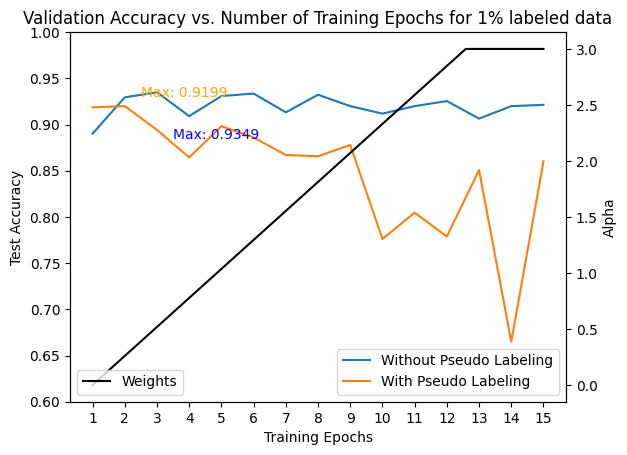

In [ ]:
hist_ft = [torch.tensor(0.8901, device='cuda:0', dtype=torch.float64), torch.tensor(0.9294, device='cuda:0', dtype=torch.float64), torch.tensor(0.9349, device='cuda:0', dtype=torch.float64), torch.tensor(0.9091, device='cuda:0', dtype=torch.float64), torch.tensor(0.9308, device='cuda:0', dtype=torch.float64), torch.tensor(0.9335, device='cuda:0', dtype=torch.float64), torch.tensor(0.9132, device='cuda:0', dtype=torch.float64), torch.tensor(0.9322, device='cuda:0', dtype=torch.float64), torch.tensor(0.9199, device='cuda:0', dtype=torch.float64), torch.tensor(0.9118, device='cuda:0', dtype=torch.float64), torch.tensor(0.9199, device='cuda:0', dtype=torch.float64), torch.tensor(0.9254, device='cuda:0', dtype=torch.float64), torch.tensor(0.9064, device='cuda:0', dtype=torch.float64), torch.tensor(0.9199, device='cuda:0', dtype=torch.float64), torch.tensor(0.9213, device='cuda:0', dtype=torch.float64)]
hist_ft_bn = histt
ohist = [h.cpu().numpy() for h in hist_ft]
shist = hist_ft_bn
alphas_0_01 = [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125, 1.25, 1.375, 1.5, 1.625, 1.75, 1.875, 2.0, 2.125, 2.25, 2.375, 2.5, 2.625, 2.75, 2.875, 3.0, 3, 3, 3, 3, 3]
x_axis_third = np.linspace(1, num_epochs, len(alphas_0_01))

fig, ax1 = plt.subplots()

ax1.set_title("Validation Accuracy vs. Number of Training Epochs for 1% labeled data")
ax1.set_xlabel("Training Epochs")
ax1.set_ylabel("Test Accuracy")
ax1.plot(range(1,num_epochs+1),ohist,label="Without Pseudo Labeling")
ax1.plot(range(1,num_epochs+1),shist,label="With Pseudo Labeling")

# Create a second y-axis
ax2 = ax1.twinx()

# Third plot
ax2.set_ylabel("Alpha")  # Set a label for the third plot's y-axis
ax2.plot(x_axis_third,alphas_0_01,label="Weights", color='Black')
ax1.set_ylim(0.6, 1)
ohist_max = max(ohist)
shist_max = max(shist)
ax1.annotate(f"Max: {ohist_max:.4f}", xy=(ohist.index(ohist_max)+1, ohist_max), xytext=(ohist.index(ohist_max)+1.5, ohist_max-0.05), color='blue')
ax1.annotate(f"Max: {shist_max:.4f}", xy=(shist.index(shist_max)+1, shist_max), xytext=(shist.index(shist_max)+1.5, shist_max+0.01), color='orange')
ax1.set_xticks(np.arange(1, num_epochs+1, 1.0))
ax1.legend(loc='lower right')
ax2.legend(loc='lower left')
plt.show()

### 10% Labeled data:

In [ ]:
criterion = nn.CrossEntropyLoss()

model_ft1, hist1 = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------
train Loss: 2.4489 Acc: 0.3543
lr1= 0.0008857184332526463
lr2= 0.0017714368665052926
val Loss: 2.8344 Acc: 0.2510
lr1= 0.0008677276608071571
lr2= 0.0017354553216143143

Epoch 1/14
----------
train Loss: 1.4085 Acc: 0.5862
lr1= 0.0009342700968562493
lr2= 0.0018685401937124986
val Loss: 1.1484 Acc: 0.6649
lr1= 0.0009464067859148538
lr2= 0.0018928135718297076

Epoch 2/14
----------
train Loss: 0.9103 Acc: 0.7154
lr1= 0.0009575176837112774
lr2= 0.0019150353674225549
val Loss: 0.8597 Acc: 0.7476
lr1= 0.0009598807887096031
lr2= 0.0019197615774192063

Epoch 3/14
----------
train Loss: 0.7188 Acc: 0.7749
lr1= 0.0009664572974836073
lr2= 0.0019329145949672146
val Loss: 0.8470 Acc: 0.7626
lr1= 0.0009604741744644525
lr2= 0.001920948348928905

Epoch 4/14
----------
train Loss: 0.5828 Acc: 0.8182
lr1= 0.0009728034589265974
lr2= 0.0019456069178531948
val Loss: 0.8019 Acc: 0.7856
lr1= 0.00096257878529803
lr2= 0.00192515757059606

Epoch 5/14
----------
train Loss: 0.5224 Acc: 0.83

In [ ]:
with open('/content/drive/MyDrive/PL_best_accuracie.txt', 'a', encoding='utf-8') as f:
  f.write('Best Val accuracies for 10% of dataset before PL 2: \n')
  f.write(f'{hist1}\n')

In [ ]:
torch.save(model_ft1.state_dict(), '/content/drive/MyDrive/resnet50_FT_0.1_labels.pt')

In [ ]:
model_ft1 = model_ft
model_ft1.load_state_dict(torch.load("/content/drive/MyDrive/resnet50_FT_0.1_labels.pt"))

<All keys matched successfully>

In [ ]:
criterion = nn.CrossEntropyLoss()

model_ft1, histt1 = train_semi_supervised(model_ft1, unlabeled_dataloaders_dict, dataloaders_dict, criterion, optimizer_ft, num_epochs=15, is_inception=(model_name=="inception"))

Epoch 0/14
----------
Test Loss: 0.5085 Acc: 0.8752

Epoch 1/14
----------
Test Loss: 0.8447 Acc: 0.7815

Epoch 2/14
----------
Test Loss: 0.7369 Acc: 0.8263

Epoch 3/14
----------
Test Loss: 0.5941 Acc: 0.8507

Epoch 4/14
----------
Test Loss: 0.7854 Acc: 0.8304

Epoch 5/14
----------
Test Loss: 0.6385 Acc: 0.8453

Epoch 6/14
----------


In [ ]:
criterion = nn.CrossEntropyLoss()

model_ft1, histt1 = train_semi_supervised(model_ft1, unlabeled_dataloaders_dict, dataloaders_dict, criterion, optimizer_ft, num_epochs=15, is_inception=(model_name=="inception"))

Epoch 0/14
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Test Loss: 0.6441 Acc: 0.8467

Epoch 1/14
----------
Test Loss: 0.4707 Acc: 0.8833

Epoch 2/14
----------
Test Loss: 0.5611 Acc: 0.8806

Epoch 3/14
----------
Test Loss: 0.6957 Acc: 0.8535

Epoch 4/14
----------
Test Loss: 0.8255 Acc: 0.8250

Epoch 5/14
----------
Test Loss: 1.0697 Acc: 0.8060

Epoch 6/14
----------
Test Loss: 1.0763 Acc: 0.7870

Epoch 7/14
----------
Test Loss: 0.8440 Acc: 0.8399

Epoch 8/14
----------
Test Loss: 1.2714 Acc: 0.7924

Epoch 9/14
----------
Test Loss: 1.1307 Acc: 0.7761

Epoch 10/14
----------
Test Loss: 1.2210 Acc: 0.7490

Epoch 11/14
----------
Test Loss: 1.2036 Acc: 0.7815

Epoch 12/14
----------
Test Loss: 1.2368 Acc: 0.7992

Epoch 13/14
----------
Test Loss: 1.2113 Acc: 0.7883

Epoch 14/14
----------
Test Loss: 1.1649 Acc: 0.7938

Training complete in 164m 1s
Pseudo Labeling : Best val Acc: 0.883311


In [ ]:
print(alpha_history)

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15000000000000002, 0.16, 0.16999999999999998, 0.18, 0.19, 0.2, 0.21000000000000002, 0.22, 0.22999999999999998, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30000000000000004, 0.31, 0.32, 0.33, 0.33999999999999997, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42000000000000004, 0.43000000000000005, 0.44, 0.44999999999999996, 0.45999999999999996, 0.47000000000000003, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.5499999999999999, 0.56, 0.5700000000000001, 0.58, 0.59, 0.6000000000000001, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.6699999999999999, 0.6799999999999999, 0.6900000000000001, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.7899999999999999, 0.8, 0.81, 0.82, 0.8300000000000001, 0.8400000000000001, 0.85, 0.8600000000000001, 0.8699999999999999, 0.88, 0.8900000000000001, 0.8999999999999999, 0.91, 0.9199999999999999, 0.9299999999999999, 0.9400000000000001, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 

In [ ]:
torch.save(model_ft1.state_dict(), '/content/drive/MyDrive/resnet50_FT_0.1_labels_PL.pt')

In [ ]:
with open('/content/drive/MyDrive/PL_best_accuracie.txt', 'a', encoding='utf-8') as f:
  f.write('Best Val accuracies for 10% of dataset with PL: \n')
  f.write(f'{histt1}\n')

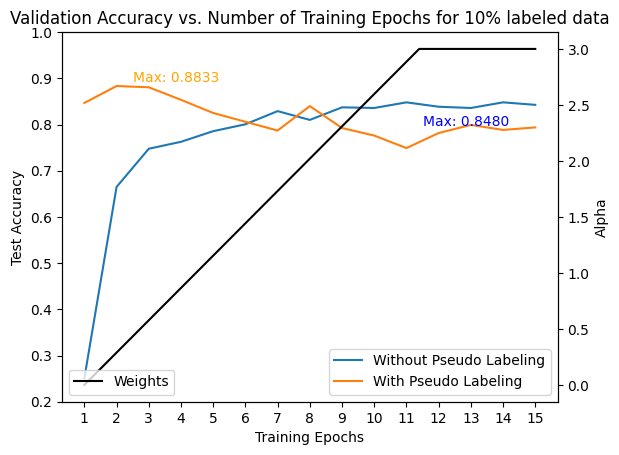

In [ ]:
hist_ft = [torch.tensor(0.2510, device='cuda:0', dtype=torch.float64), torch.tensor(0.6649, device='cuda:0', dtype=torch.float64), torch.tensor(0.7476, device='cuda:0', dtype=torch.float64), torch.tensor(0.7626, device='cuda:0', dtype=torch.float64), torch.tensor(0.7856, device='cuda:0', dtype=torch.float64), torch.tensor(0.8005, device='cuda:0', dtype=torch.float64), torch.tensor(0.8290, device='cuda:0', dtype=torch.float64), torch.tensor(0.8100, device='cuda:0', dtype=torch.float64), torch.tensor(0.8372, device='cuda:0', dtype=torch.float64), torch.tensor(0.8358, device='cuda:0', dtype=torch.float64), torch.tensor(0.8480, device='cuda:0', dtype=torch.float64), torch.tensor(0.8385, device='cuda:0', dtype=torch.float64), torch.tensor(0.8358, device='cuda:0', dtype=torch.float64), torch.tensor(0.8480, device='cuda:0', dtype=torch.float64), torch.tensor(0.8426, device='cuda:0', dtype=torch.float64)]
hist_ft_bn = [0.8724559023066486, 0.8236092265943012, 0.824966078697422, 0.830393487109905, 0.8371777476255088, 0.8168249660786974, 0.7951153324287653, 0.8005427408412483, 0.7991858887381276, 0.7883310719131614, 0.7842605156037992, 0.7991858887381276, 0.7774762550881954, 0.7856173677069199, 0.7584803256445047]
ohist = [h.cpu().numpy() for h in hist_ft]
shist = histt1
alphas_0_1 = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15000000000000002, 0.16, 0.16999999999999998, 0.18, 0.19, 0.2, 0.21000000000000002, 0.22, 0.22999999999999998, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30000000000000004, 0.31, 0.32, 0.33, 0.33999999999999997, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42000000000000004, 0.43000000000000005, 0.44, 0.44999999999999996, 0.45999999999999996, 0.47000000000000003, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.5499999999999999, 0.56, 0.5700000000000001, 0.58, 0.59, 0.6000000000000001, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.6699999999999999, 0.6799999999999999, 0.6900000000000001, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.7899999999999999, 0.8, 0.81, 0.82, 0.8300000000000001, 0.8400000000000001, 0.85, 0.8600000000000001, 0.8699999999999999, 0.88, 0.8900000000000001, 0.8999999999999999, 0.91, 0.9199999999999999, 0.9299999999999999, 0.9400000000000001, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.0499999999999998, 1.06, 1.07, 1.08, 1.09, 1.0999999999999999, 1.1099999999999999, 1.12, 1.13, 1.1400000000000001, 1.1500000000000001, 1.16, 1.17, 1.18, 1.19, 1.2000000000000002, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.33, 1.3399999999999999, 1.35, 1.3599999999999999, 1.37, 1.3800000000000001, 1.39, 1.4, 1.41, 1.42, 1.4300000000000002, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5, 1.5099999999999998, 1.52, 1.53, 1.54, 1.5500000000000003, 1.56, 1.5699999999999998, 1.5799999999999998, 1.59, 1.6, 1.6099999999999999, 1.62, 1.63, 1.64, 1.6500000000000001, 1.6600000000000001, 1.67, 1.6800000000000002, 1.69, 1.7, 1.71, 1.7200000000000002, 1.73, 1.7399999999999998, 1.75, 1.76, 1.77, 1.7800000000000002, 1.79, 1.7999999999999998, 1.81, 1.82, 1.83, 1.8399999999999999, 1.85, 1.8599999999999999, 1.8699999999999999, 1.8800000000000001, 1.8900000000000001, 1.9, 1.9100000000000001, 1.92, 1.93, 1.94, 1.9500000000000002, 1.96, 1.9699999999999998, 1.98, 1.99, 2.0, 2.0100000000000002, 2.02, 2.03, 2.04, 2.05, 2.06, 2.07, 2.08, 2.09, 2.0999999999999996, 2.1100000000000003, 2.12, 2.13, 2.14, 2.15, 2.16, 2.17, 2.18, 2.19, 2.1999999999999997, 2.21, 2.2199999999999998, 2.23, 2.24, 2.25, 2.26, 2.27, 2.2800000000000002, 2.29, 2.3000000000000003, 2.31, 2.32, 2.33, 2.34, 2.35, 2.36, 2.37, 2.38, 2.3899999999999997, 2.4000000000000004, 2.41, 2.42, 2.43, 2.44, 2.45, 2.46, 2.47, 2.48, 2.4899999999999998, 2.5, 2.51, 2.52, 2.5300000000000002, 2.54, 2.55, 2.56, 2.5700000000000003, 2.58, 2.59, 2.6, 2.61, 2.62, 2.63, 2.64, 2.65, 2.66, 2.67, 2.6799999999999997, 2.69, 2.7, 2.71, 2.7199999999999998, 2.73, 2.74, 2.75, 2.7600000000000002, 2.77, 2.78, 2.79, 2.8, 2.81, 2.82, 2.83, 2.84, 2.8499999999999996, 2.8600000000000003, 2.87, 2.88, 2.89, 2.9, 2.91, 2.92, 2.93, 2.94, 2.9499999999999997, 2.96, 2.9699999999999998, 2.98, 2.99, 3.0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
x_axis_third = np.linspace(1, num_epochs, len(alphas_0_1))

fig, ax1 = plt.subplots()

ax1.set_title("Validation Accuracy vs. Number of Training Epochs for 10% labeled data")
ax1.set_xlabel("Training Epochs")
ax1.set_ylabel("Test Accuracy")
ax1.plot(range(1,num_epochs+1),ohist,label="Without Pseudo Labeling")
ax1.plot(range(1,num_epochs+1),shist,label="With Pseudo Labeling")

# Create a second y-axis
ax2 = ax1.twinx()

# Third plot
ax2.set_ylabel("Alpha")  # Set a label for the third plot's y-axis
ax2.plot(x_axis_third,alphas_0_1,label="Weights", color='Black')
ax1.set_ylim(0.2, 1)
ohist_max = max(ohist)
shist_max = max(shist)
ax1.annotate(f"Max: {ohist_max:.4f}", xy=(ohist.index(ohist_max)+1, ohist_max), xytext=(ohist.index(ohist_max)+1.5, ohist_max-0.05), color='blue')
ax1.annotate(f"Max: {shist_max:.4f}", xy=(shist.index(shist_max)+1, shist_max), xytext=(shist.index(shist_max)+1.5, shist_max+0.01), color='orange')
ax1.set_xticks(np.arange(1, num_epochs+1, 1.0))
ax1.legend(loc='lower right')
ax2.legend(loc='lower left')
plt.show()

In [ ]:
len(alphas_0_1)

510

### 1% Labeled

In [ ]:
criterion = nn.CrossEntropyLoss()

model_ft2, hist2 = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


train Loss: 3.0569 Acc: 0.0940
lr1= 0.0008573447083204221
lr2= 0.0017146894166408441
val Loss: 4.9163 Acc: 0.0570
lr1= 0.0007705723759751685
lr2= 0.001541144751950337

Epoch 1/14
----------
train Loss: 2.1302 Acc: 0.2991
lr1= 0.0009005927171734324
lr2= 0.0018011854343468648
val Loss: 5.4450 Acc: 0.1818
lr1= 0.0007458984479986129
lr2= 0.0014917968959972257

Epoch 2/14
----------
train Loss: 1.5544 Acc: 0.5299
lr1= 0.0009274607093245895
lr2= 0.001854921418649179
val Loss: 5.7485 Acc: 0.2103
lr1= 0.000731735927792277
lr2= 0.001463471855584554

Epoch 3/14
----------
train Loss: 1.2020 Acc: 0.7009
lr1= 0.0009439047385280968
lr2= 0.0018878094770561937
val Loss: 5.7926 Acc: 0.2374
lr1= 0.0007296781763174263
lr2= 0.0014593563526348525

Epoch 4/14
----------
train Loss: 0.9140 Acc: 0.8120
lr1= 0.0009573467742343913
lr2= 0.0019146935484687826
val Loss: 5.8853 Acc: 0.2605
lr1= 0.0007253516141476538
lr2= 0.0014507032282953076

Epoch 5/14
----------
train Loss: 0.9062 Acc: 0.7692
lr1= 0.00095770990

In [ ]:
torch.save(model_ft2.state_dict(), '/content/drive/MyDrive/resnet50_FT_0.01_labels.pt')

In [ ]:
model_ft2 = model_ft

model_ft2.load_state_dict(torch.load("/content/drive/MyDrive/resnet50_FT_0.01_labels.pt"))

<All keys matched successfully>

In [ ]:
with open('/content/drive/MyDrive/PL_best_accuracie.txt', 'a', encoding='utf-8') as f:
  f.write('Best Val accuracies for 1% of dataset before PL 3: \n')
  f.write(f'{hist2}\n')

**First try**

In [ ]:
model_ft2, histt2 = train_semi_supervised(model_ft2, unlabeled_dataloaders_dict, dataloaders_dict, criterion, optimizer_ft, num_epochs=15, is_inception=(model_name=="inception"))

Epoch 0/14
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Test Loss: 11.6834 Acc: 0.2076

Epoch 1/14
----------
Test Loss: 17.2125 Acc: 0.1995

Epoch 2/14
----------
Test Loss: 12.7652 Acc: 0.2388

Epoch 3/14
----------
Test Loss: 16.4684 Acc: 0.2252

Epoch 4/14
----------
Test Loss: 13.4287 Acc: 0.2347

Epoch 5/14
----------
Test Loss: 11.7415 Acc: 0.2442

Epoch 6/14
----------
Test Loss: 13.0025 Acc: 0.2388

Epoch 7/14
----------
Test Loss: 12.6966 Acc: 0.2225

Epoch 8/14
----------
Test Loss: 13.9348 Acc: 0.2456

Epoch 9/14
----------
Test Loss: 13.6818 Acc: 0.2429

Epoch 10/14
----------
Test Loss: 11.9690 Acc: 0.2307

Epoch 11/14
----------
Test Loss: 12.3331 Acc: 0.2347

Epoch 12/14
----------
Test Loss: 11.4072 Acc: 0.2225

Epoch 13/14
----------
Test Loss: 11.1592 Acc: 0.2157

Epoch 14/14
----------
Test Loss: 11.3619 Acc: 0.2130

Training complete in 57m 40s
Pseudo Labeling : Best val Acc: 0.245590


In [ ]:
torch.save(model_ft2.state_dict(), '/content/drive/MyDrive/resnet50_FT_0.01_labels_PL.pt')

**Second try**

In [ ]:
criterion = nn.CrossEntropyLoss()

model_ft2, histt2 = train_semi_supervised(model_ft2, unlabeled_dataloaders_dict, dataloaders_dict, criterion, optimizer_ft, num_epochs=15, is_inception=(model_name=="inception"))

Epoch 0/14
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Test Loss: 10.0373 Acc: 0.2727

Epoch 1/14
----------
Test Loss: 11.3145 Acc: 0.2782

Epoch 2/14
----------
Test Loss: 12.0037 Acc: 0.2714

Epoch 3/14
----------
Test Loss: 13.1514 Acc: 0.2578

Epoch 4/14
----------
Test Loss: 13.1113 Acc: 0.2673

Epoch 5/14
----------
Test Loss: 14.3268 Acc: 0.2551

Epoch 6/14
----------
Test Loss: 12.0875 Acc: 0.2456

Epoch 7/14
----------
Test Loss: 9.9948 Acc: 0.2307

Epoch 8/14
----------
Test Loss: 13.5566 Acc: 0.2239

Epoch 9/14
----------
Test Loss: 11.6195 Acc: 0.2157

Epoch 10/14
----------
Test Loss: 12.7078 Acc: 0.2198

Epoch 11/14
----------
Test Loss: 13.5978 Acc: 0.2429

Epoch 12/14
----------
Test Loss: 13.2103 Acc: 0.2402

Epoch 13/14
----------
Test Loss: 11.9155 Acc: 0.2225

Epoch 14/14
----------
Test Loss: 12.8253 Acc: 0.2388

Training complete in 96m 9s
Pseudo Labeling : Best val Acc: 0.278155


In [ ]:
with open('/content/drive/MyDrive/PL_best_accuracie.txt', 'a', encoding='utf-8') as f:
  f.write('Best Val accuracies for 1% of dataset with PL 2: \n')
  f.write(f'{histt2}\n')

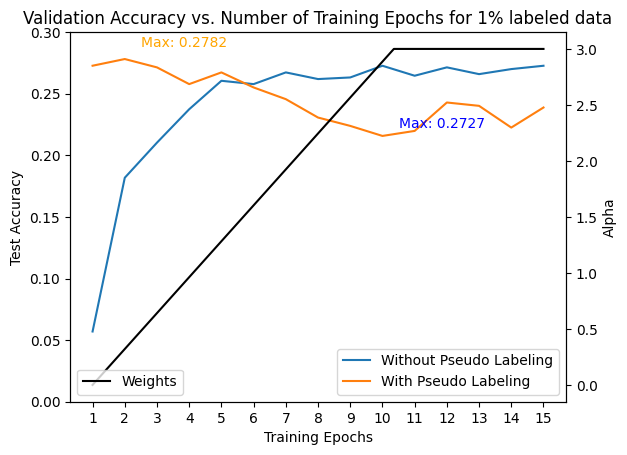

In [ ]:
hist_ft = [torch.tensor(0.0570, device='cuda:0', dtype=torch.float64), torch.tensor(0.1818, device='cuda:0', dtype=torch.float64), torch.tensor(0.2103, device='cuda:0', dtype=torch.float64), torch.tensor(0.2374, device='cuda:0', dtype=torch.float64), torch.tensor(0.2605, device='cuda:0', dtype=torch.float64), torch.tensor(0.2578, device='cuda:0', dtype=torch.float64), torch.tensor(0.2673, device='cuda:0', dtype=torch.float64), torch.tensor(0.2619, device='cuda:0', dtype=torch.float64), torch.tensor(0.2632, device='cuda:0', dtype=torch.float64), torch.tensor(0.2727, device='cuda:0', dtype=torch.float64), torch.tensor(0.2646, device='cuda:0', dtype=torch.float64), torch.tensor(0.2714, device='cuda:0', dtype=torch.float64), torch.tensor(0.2659, device='cuda:0', dtype=torch.float64), torch.tensor(0.2700, device='cuda:0', dtype=torch.float64), torch.tensor(0.2727, device='cuda:0', dtype=torch.float64)]
hist_ft_bn = histt2
ohist = [h.cpu().numpy() for h in hist_ft]
shist = hist_ft_bn
alphas_0_01 = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15000000000000002, 0.16, 0.16999999999999998, 0.18, 0.19, 0.2, 0.21000000000000002, 0.22, 0.22999999999999998, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30000000000000004, 0.31, 0.32, 0.33, 0.33999999999999997, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42000000000000004, 0.43000000000000005, 0.44, 0.44999999999999996, 0.45999999999999996, 0.47000000000000003, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.5499999999999999, 0.56, 0.5700000000000001, 0.58, 0.59, 0.6000000000000001, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.6699999999999999, 0.6799999999999999, 0.6900000000000001, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.7899999999999999, 0.8, 0.81, 0.82, 0.8300000000000001, 0.8400000000000001, 0.85, 0.8600000000000001, 0.8699999999999999, 0.88, 0.8900000000000001, 0.8999999999999999, 0.91, 0.9199999999999999, 0.9299999999999999, 0.9400000000000001, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.0499999999999998, 1.06, 1.07, 1.08, 1.09, 1.0999999999999999, 1.1099999999999999, 1.12, 1.13, 1.1400000000000001, 1.1500000000000001, 1.16, 1.17, 1.18, 1.19, 1.2000000000000002, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.33, 1.3399999999999999, 1.35, 1.3599999999999999, 1.37, 1.3800000000000001, 1.39, 1.4, 1.41, 1.42, 1.4300000000000002, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5, 1.5099999999999998, 1.52, 1.53, 1.54, 1.5500000000000003, 1.56, 1.5699999999999998, 1.5799999999999998, 1.59, 1.6, 1.6099999999999999, 1.62, 1.63, 1.64, 1.6500000000000001, 1.6600000000000001, 1.67, 1.6800000000000002, 1.69, 1.7, 1.71, 1.7200000000000002, 1.73, 1.7399999999999998, 1.75, 1.76, 1.77, 1.7800000000000002, 1.79, 1.7999999999999998, 1.81, 1.82, 1.83, 1.8399999999999999, 1.85, 1.8599999999999999, 1.8699999999999999, 1.8800000000000001, 1.8900000000000001, 1.9, 1.9100000000000001, 1.92, 1.93, 1.94, 1.9500000000000002, 1.96, 1.9699999999999998, 1.98, 1.99, 2.0, 2.0100000000000002, 2.02, 2.03, 2.04, 2.05, 2.06, 2.07, 2.08, 2.09, 2.0999999999999996, 2.1100000000000003, 2.12, 2.13, 2.14, 2.15, 2.16, 2.17, 2.18, 2.19, 2.1999999999999997, 2.21, 2.2199999999999998, 2.23, 2.24, 2.25, 2.26, 2.27, 2.2800000000000002, 2.29, 2.3000000000000003, 2.31, 2.32, 2.33, 2.34, 2.35, 2.36, 2.37, 2.38, 2.3899999999999997, 2.4000000000000004, 2.41, 2.42, 2.43, 2.44, 2.45, 2.46, 2.47, 2.48, 2.4899999999999998, 2.5, 2.51, 2.52, 2.5300000000000002, 2.54, 2.55, 2.56, 2.5700000000000003, 2.58, 2.59, 2.6, 2.61, 2.62, 2.63, 2.64, 2.65, 2.66, 2.67, 2.6799999999999997, 2.69, 2.7, 2.71, 2.7199999999999998, 2.73, 2.74, 2.75, 2.7600000000000002, 2.77, 2.78, 2.79, 2.8, 2.81, 2.82, 2.83, 2.84, 2.8499999999999996, 2.8600000000000003, 2.87, 2.88, 2.89, 2.9, 2.91, 2.92, 2.93, 2.94, 2.9499999999999997, 2.96, 2.9699999999999998, 2.98, 2.99, 3.0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
x_axis_third = np.linspace(1, num_epochs, len(alphas_0_01))

fig, ax1 = plt.subplots()

ax1.set_title("Validation Accuracy vs. Number of Training Epochs for 1% labeled data")
ax1.set_xlabel("Training Epochs")
ax1.set_ylabel("Test Accuracy")
ax1.plot(range(1,num_epochs+1),ohist,label="Without Pseudo Labeling")
ax1.plot(range(1,num_epochs+1),shist,label="With Pseudo Labeling")

# Create a second y-axis
ax2 = ax1.twinx()

# Third plot
ax2.set_ylabel("Alpha")  # Set a label for the third plot's y-axis
ax2.plot(x_axis_third,alphas_0_01,label="Weights", color='Black')
ax1.set_ylim(0, 0.3)
ohist_max = max(ohist)
shist_max = max(shist)
ax1.annotate(f"Max: {ohist_max:.4f}", xy=(ohist.index(ohist_max)+1, ohist_max), xytext=(ohist.index(ohist_max)+1.5, ohist_max-0.05), color='blue')
ax1.annotate(f"Max: {shist_max:.4f}", xy=(shist.index(shist_max)+1, shist_max), xytext=(shist.index(shist_max)+1.5, shist_max+0.01), color='orange')
ax1.set_xticks(np.arange(1, num_epochs+1, 1.0))
ax1.legend(loc='lower right')
ax2.legend(loc='lower left')
plt.show()

In [ ]:
len(alphas_0_01)

555

#Training function for Mean Teacher

In [ ]:
def train_model(model, ema_model,p,dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    MSELoss = nn.MSELoss()
    total_iterations = num_epochs*(len(dataloaders['train']))
    iteration=0
    beta = 0.99

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        if epoch == 10:
          beta=0.999

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                ema_model.train()
            else:
                model.eval()   # Set model to evaluate mode
                ema_model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, breed, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                breed = breed.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        # loss1 = criterion(outputs, labels) #
                        loss1 = criterion(outputs, breed) #
                        # loss2 = criterion(aux_outputs, labels)#/
                        loss2 = criterion(aux_outputs, breed)#
                        loss = loss1 + 0.4*loss2
                    else:
                        student_noise = torchvision.transforms.GaussianBlur((7,13))
                        student_inputs = student_noise(inputs)
                        student_inputs = student_inputs.to(device)
                        teacher_noise = torchvision.transforms.GaussianBlur((7,13))
                        teacher_inputs = teacher_noise(inputs)
                        teacher_inputs = teacher_inputs.to(device)

                        outputs = model(student_inputs)
                        ema_outputs = ema_model(teacher_inputs)
                        
                        # loss = criterion(outputs, labels)
                        #supervised_loss = criterion(outputs,breed)
                        consistency_coeff = sigmoid_rampup(iteration,total_iterations)
                        iteration+=1
                        unsupervised_loss = MSELoss(outputs,ema_outputs)
                        loss = consistency_coeff*unsupervised_loss

                        #if the batch contains labels
                        rand = random.uniform(0,1)
                        if rand>p:
                          supervised_loss = criterion(outputs,breed)
                          loss += supervised_loss
                        
                        _, preds = torch.max(outputs, 1)

                        if phase == 'train':
                          loss.backward()
                          optimizer.step()
                          update_moving_average(model,ema_model,beta)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                # running_corrects += torch.sum(preds == labels.data)
                running_corrects += torch.sum(preds == breed.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            scheduler.step(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('lr1=',optimizer.param_groups[0]["lr"])
            print('lr2=',optimizer.param_groups[1]["lr"])

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def update_moving_average(model,ema_model,beta):
  for ema_param, param in zip(ema_model.parameters(), model.parameters()):
        ema_param.data.mul_(beta).add_(1 - beta, param.data)

def sigmoid_rampup(current, rampup_length):
    """Exponential rampup from https://arxiv.org/abs/1610.02242"""
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current, 0.0, rampup_length)
        phase = 1.0 - current / rampup_length
        return float(np.exp(-5.0 * phase * phase))

#Mean Teacher

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()
unlabel_proportion = 0.90

# Train and evaluate
model_ft, hist = train_model(model_ft, model_ema,unlabel_proportion, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------


<ipython-input-19-12acb56657cc>:118: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  ema_param.data.mul_(beta).add_(1 - beta, param.data)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


train Loss: 0.3309 Acc: 0.3659
lr1= 0.000984557632948972
lr2= 0.001969115265897944
val Loss: 0.1641 Acc: 0.7558
lr1= 0.0009923398506815184
lr2= 0.0019846797013630367

Epoch 1/14
----------


In [ ]:
# Saving the model and the evaluation accuracy:

torch.save(model_ft.state_dict(), '/content/drive/MyDrive/weights/resnet50_noFT.pt')

with open('/content/drive/MyDrive/resnet50_noFT_acc.txt', 'a', encoding='utf-8') as f:
  f.write('Best Val: \n')
  f.write(f'{hist}\n')

In [ ]:
test_dataset = CustomImageDataset("/content/drive/MyDrive/PET/oxford-iiit-pet/annotations/test.txt",
                         "/content/drive/MyDrive/PET/oxford-iiit-pet/images",
                         transform=val_transform)

test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

model_ft.load_state_dict(torch.load("/content/drive/MyDrive/weights/resnet50_noFT.pt"))
model_ft.eval()

running_corrects = 0
for inputs, breed, labels in test_dataloader:
    inputs = inputs.to(device)
    breed = breed.to(device)

    outputs = model_ft(inputs)

    _, preds = torch.max(outputs, 1)
    running_corrects += torch.sum(preds == breed.data)

  
test_acc =  running_corrects.double() / len(test_dataloader.dataset)

print(test_acc)


FileNotFoundError: ignored

### Comparaison between fine-tunning the last layer and 

1.   Fine-tuning batch normalization
2.   Data augmenting
3.   Finetuning more layers



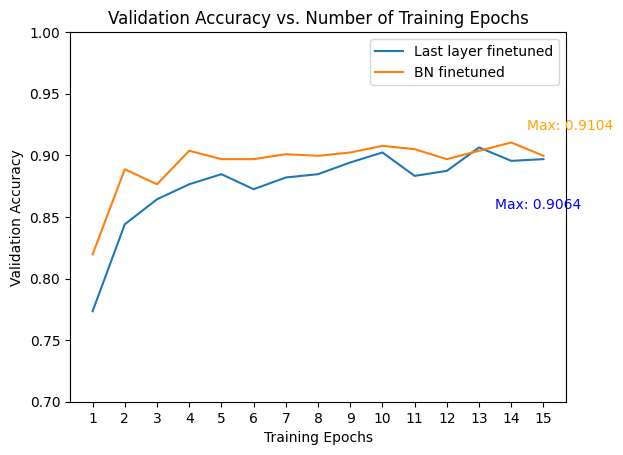

In [ ]:
# Getting the accuracies for each epoch from the file val_accuracies.txt:

hist_ft = [torch.tensor(0.7734, device='cuda:0', dtype=torch.float64), torch.tensor(0.8440, device='cuda:0', dtype=torch.float64), torch.tensor(0.8643, device='cuda:0', dtype=torch.float64), torch.tensor(0.8765, device='cuda:0', dtype=torch.float64), torch.tensor(0.8847, device='cuda:0', dtype=torch.float64), torch.tensor(0.8725, device='cuda:0', dtype=torch.float64), torch.tensor(0.8820, device='cuda:0', dtype=torch.float64), torch.tensor(0.8847, device='cuda:0', dtype=torch.float64), torch.tensor(0.8942, device='cuda:0', dtype=torch.float64), torch.tensor(0.9023, device='cuda:0', dtype=torch.float64), torch.tensor(0.8833, device='cuda:0', dtype=torch.float64), torch.tensor(0.8874, device='cuda:0', dtype=torch.float64), torch.tensor(0.9064, device='cuda:0', dtype=torch.float64), torch.tensor(0.8955, device='cuda:0', dtype=torch.float64), torch.tensor(0.8969, device='cuda:0', dtype=torch.float64)]

hist_ft_bn = [torch.tensor(0.8195, device='cuda:0', dtype=torch.float64), torch.tensor(0.8887, device='cuda:0', dtype=torch.float64), torch.tensor(0.8765, device='cuda:0', dtype=torch.float64), torch.tensor(0.9037, device='cuda:0', dtype=torch.float64), torch.tensor(0.8969, device='cuda:0', dtype=torch.float64), torch.tensor(0.8969, device='cuda:0', dtype=torch.float64), torch.tensor(0.9009, device='cuda:0', dtype=torch.float64), torch.tensor(0.8996, device='cuda:0', dtype=torch.float64), torch.tensor(0.9023, device='cuda:0', dtype=torch.float64), torch.tensor(0.9077, device='cuda:0', dtype=torch.float64), torch.tensor(0.9050, device='cuda:0', dtype=torch.float64), torch.tensor(0.8969, device='cuda:0', dtype=torch.float64), torch.tensor(0.9037, device='cuda:0', dtype=torch.float64), torch.tensor(0.9104, device='cuda:0', dtype=torch.float64), torch.tensor(0.8996, device='cuda:0', dtype=torch.float64)]

ohist = [h.cpu().numpy() for h in hist_ft]
shist = [h.cpu().numpy() for h in hist_ft_bn]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Last layer finetuned")
plt.plot(range(1,num_epochs+1),shist,label="BN finetuned")
plt.ylim(0.7, 1)
ohist_max = max(ohist)
shist_max = max(shist)
plt.annotate(f"Max: {ohist_max:.4f}", xy=(ohist.index(ohist_max)+1, ohist_max), xytext=(ohist.index(ohist_max)+1.5, ohist_max-0.05), color='blue')
plt.annotate(f"Max: {shist_max:.4f}", xy=(shist.index(shist_max)+1, shist_max), xytext=(shist.index(shist_max)+1.5, shist_max+0.01), color='orange')
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()



Comparison with Model Trained from Scratch
------------------------------------------

Just for fun, lets see how the model learns if we do not use transfer
learning. The performance of finetuning vs. feature extracting depends
largely on the dataset but in general both transfer learning methods
produce favorable results in terms of training time and overall accuracy
versus a model trained from scratch.




In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0/14
----------
train Loss: 0.6842 Acc: 0.6354
val Loss: 0.6145 Acc: 0.6771

Epoch 1/14
----------
train Loss: 0.6886 Acc: 0.6357
val Loss: 0.7270 Acc: 0.6771

Epoch 2/14
----------
train Loss: 0.6550 Acc: 0.6381
val Loss: 1.0460 Acc: 0.6771

Epoch 3/14
----------
train Loss: 0.6488 Acc: 0.6504
val Loss: 0.5952 Acc: 0.6771

Epoch 4/14
----------
train Loss: 0.6402 Acc: 0.6524
val Loss: 0.6026 Acc: 0.6784

Epoch 5/14
----------
train Loss: 0.6288 Acc: 0.6670


Final Thoughts and Where to Go Next
-----------------------------------

Try running some of the other models and see how good the accuracy gets.
Also, notice that feature extracting takes less time because in the
backward pass we do not have to calculate most of the gradients. There
are many places to go from here. You could:

-  Run this code with a harder dataset and see some more benefits of
   transfer learning
-  Using the methods described here, use transfer learning to update a
   different model, perhaps in a new domain (i.e. NLP, audio, etc.)
-  Once you are happy with a model, you can export it as an ONNX model,
   or trace it using the hybrid frontend for more speed and optimization
   opportunities.


